In [1]:
import nest_asyncio
nest_asyncio.apply()

In [14]:
import collections

import numpy as np
import tensorflow as tf
import tensorflow_federated as tff

tff.framework.set_default_context(tff.test.ReferenceExecutor())

In [3]:
tff.federated_computation
def hello_world():
    return 'Hello World!'
hello_world()

'Hello World!'

In [4]:
mnist_train, mnist_test = tf.keras.datasets.mnist.load_data()

In [5]:
[(x.dtype, x.shape) for x in mnist_train]

[(dtype('uint8'), (60000, 28, 28)), (dtype('uint8'), (60000,))]

In [9]:
NUM_EXAMPLES_PER_USER = 1000
BATCH_SIZE = 100

def get_data_for_digit(source, digit):
    output_sequence = []
    all_samples = [i for i, d in enumerate(source[1]) if d == digit]
    for i in range(0, min(len(all_samples), NUM_EXAMPLES_PER_USER), BATCH_SIZE):
        batch_samples = all_samples[i:i + BATCH_SIZE]
        output_sequence.append({
            'x':
                np.array([source[0][i].flatten() / 255.0 for i in batch_samples], dtype=np.float32),
            'y':
                np.array([source[1][i] for i in batch_samples], dtype=np.int32)
        })
    return output_sequence

federated_train_data = [get_data_for_digit(mnist_train, d) for d in range(10)]

federated_test_data = [get_data_for_digit(mnist_test, d) for d in range(10)]

In [10]:
federated_train_data[5][-1]['y']

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5], dtype=int32)

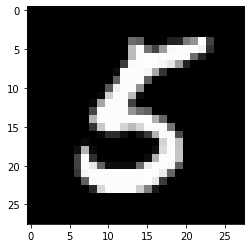

In [11]:
from matplotlib import pyplot as plt

plt.imshow(federated_train_data[5][-1]['x'][-1].reshape(28, 28), cmap='gray')
plt.grid(False)
plt.show()


In [12]:
BATCH_SPEC = collections.OrderedDict(
    x=tf.TensorSpec(shape=[None, 784], dtype=tf.float32),
    y=tf.TensorSpec(shape=[None], dtype=tf.int32)
)
BATCH_TYPE = tff.to_type(BATCH_SPEC)

str(BATCH_TYPE)

'<x=float32[?,784],y=int32[?]>'

In [13]:
MODEL_SPEC = collections.OrderedDict(
    weights=tf.TensorSpec(shape=[784, 10], dtype=tf.float32),
    bias=tf.TensorSpec(shape=[10], dtype=tf.float32)
)
MODEL_TYPE = tff.to_type(MODEL_SPEC)

print(MODEL_TYPE)

<weights=float32[784,10],bias=float32[10]>


In [16]:
@tf.function
def forward_pass(model, batch):
    predicted_y = tf.nn.softmax(
        tf.matmul(batch['x'], model['weights']) + model['bias'])
    return -tf.reduce_mean(
        tf.reduce_sum(
            tf.one_hot(batch['y'], 10) * tf.math.log(predicted_y), axis=[1]))

@tff.tf_computation(MODEL_TYPE, BATCH_TYPE)
def batch_loss(model, batch):
    return forward_pass(model, batch)

In [17]:
initial_model = collections.OrderedDict(
    weights=np.zeros([784, 10], dtype=np.float32),
    bias=np.zeros([10], dtype=np.float32))

sample_batch = federated_train_data[5][-1]

batch_loss(initial_model, sample_batch)


2.3025854

In [19]:
@tff.tf_computation(MODEL_TYPE, BATCH_TYPE, tf.float32)
def batch_train(initial_model, batch, learning_rate):
    model_vars = collections.OrderedDict([
        (name, tf.Variable(name=name, initial_value=value))
        for name, value in initial_model.items()
    ])
    optimizer = tf.keras.optimizers.SGD(learning_rate)
    
    @tf.function
    def _train_on_batch(model_vars, batch):
        with tf.GradientTape() as tape:
            loss = forward_pass(model_vars, batch)
        grads = tape.gradient(loss, model_vars)
        optimizer.apply_gradients(
            zip(tf.nest.flatten(grads), tf.nest.flatten(model_vars)))
        return model_vars
    return _train_on_batch(model_vars, batch)

In [22]:
model = initial_model
losses = []
for _ in range(5):
    model = batch_train(model, sample_batch, 0.1)
    losses.append(batch_loss(model, sample_batch))

losses

[0.19690022, 0.13176315, 0.10113225, 0.08273812, 0.07030139]

In [23]:
LOCAL_DATA_TYPE = tff.SequenceType(BATCH_TYPE)

@tff.federated_computation(MODEL_TYPE, tf.float32, LOCAL_DATA_TYPE)
def local_train(initial_model, learning_rate, all_batches):
    @tff.federated_computation(MODEL_TYPE, BATCH_TYPE)
    def batch_fn(model, batch):
        return batch_train(model, batch, learning_rate)
    return tff.sequence_reduce(all_batches, initial_model, batch_fn)

In [27]:
locally_trained_model = local_train(initial_model, 0.1, federated_train_data[5])


In [28]:
@tff.federated_computation(MODEL_TYPE, LOCAL_DATA_TYPE)
def local_eval(model, all_batches):
  # TODO(b/120157713): Replace with `tff.sequence_average()` once implemented.
    return tff.sequence_sum(
        tff.sequence_map(
        tff.federated_computation(lambda b: batch_loss(model, b), BATCH_TYPE),
        all_batches))


In [29]:
SERVER_MODEL_TYPE = tff.FederatedType(MODEL_TYPE, tff.SERVER)
CLIENT_DATA_TYPE = tff.FederatedType(LOCAL_DATA_TYPE, tff.CLIENTS)


In [30]:
@tff.federated_computation(SERVER_MODEL_TYPE, CLIENT_DATA_TYPE)
def federated_eval(model, data):
    return tff.federated_mean(
      tff.federated_map(local_eval, [tff.federated_broadcast(model), data]))


In [31]:
SERVER_FLOAT_TYPE = tff.FederatedType(tf.float32, tff.SERVER)


@tff.federated_computation(SERVER_MODEL_TYPE, SERVER_FLOAT_TYPE,
                           CLIENT_DATA_TYPE)
def federated_train(model, learning_rate, data):
    return tff.federated_mean(
      tff.federated_map(local_train, [
          tff.federated_broadcast(model),
          tff.federated_broadcast(learning_rate), data
      ]))


In [ ]:
model = initial_model
learning_rate = 0.1
for round_num in range(5):
    model = federated_train(model, learning_rate, federated_train_data)
    learning_rate = learning_rate * 0.9
    loss = federated_eval(model, federated_train_data)
    print('round {}, loss={}'.format(round_num, loss))


round 0, loss=21.60552406311035
round 1, loss=20.365678787231445
round 2, loss=19.27480125427246
round 3, loss=18.31110954284668
